<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 64
testBlockSize = 400
numVars = 2
numYs = 1
numPoints = 200
target = 'Skeleton'
const_range = [-2.1, 2.1] # constant range to generate during training only if target is Skeleton
decimals = 8 # decimals of the points only if target is Skeleton
trainRange = [-3.0,3.0] # support range to generate during training only if target is Skeleton
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "2_var_dataset"

In [5]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [6]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 499035 examples, 30 unique.
id:183997
outputs:C*sin(C*x1+C*x2)+C>_________________________________________________
variables:2


In [7]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 938 examples, 30 unique.
tensor(-2.9995) tensor(2.9966)
id:422
outputs:C*x2+C>__________________________________________________________
variables:2


In [8]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np
from sympy import sympify, Symbol, sin, cos, log, exp


def validate_prediction(
    skeleton, variables=["x1", "x2", "x3", "x4", "x5"], constant_symbol="C"
):
    local_dict = {var: Symbol(var) for var in variables}
    local_dict[constant_symbol] = Symbol(constant_symbol)

    local_dict.update(
        {
            "sin": sin,
            "cos": cos,
            "log": log,
            "exp": exp,
        }
    )

    try:
        expr = sympify(
            skeleton, locals=local_dict, evaluate=False, convert_xor=True
        )
    except Exception as e:
        return False

    return True

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton

            #if not validate_prediction(predicted_skeleton):
            #    continue

            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                continue
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                continue
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)

            # Compute error and store results
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [9]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: 0.5174671245230469*x1+-0.7406691809860964*x2+1.263293937708446*sin(-0.22545389409558148*x1**4)+-0.14261905522141194
Predicted: 0.3353053420156767*x1+-0.4221504052294602*x2+-0.08908435248307434
Err:0.05021437557825054
----------

Target: -1.4907400077539474*x1**2+-1.328483913046248*x1+0.8513612467217766
Predicted: -1.490738716722187*x1**2+-1.3284863712909787*x1+0.8513620639030437
Err:3.489997034320843e-13
----------

Target: -1.7755866583223054*sin(-1.1100938861843046*x2+-1.1466669734218355)+0.1648660022213173
Predicted: 1.0*sin(1.0*x2)+)
Err:646.8920795707276
----------

Target: -0.6956032340739147*x1*x2+1.7923780494875317
Predicted: -0.1084417147780869*x1+0.18495377751412925*x2+0.4318572092306043
Err:0.7751882043248828
----------

Target: -0.7903704913780463*log(-0.17860998540162787*log(0.14312893673578975*x2+-1.3192892791902668))/1.2017067190976967*sin(0.09774665675982597*x1*x2+1.1539890385847147*x1)+0.41917577950681384
Predicted: 0.006367533679500992*x2+0.010938793045510278

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.03718138534815996*x2+-0.7516879461440131
Predicted: 1.0*x2(1.0*x2)+1.0
Err:937.7988226786732
----------

Target: 1.0238159481286426*x1**3*x2+-0.9384811198305201*x1+0.35102668691973626
Predicted: -2.1417997254808167e-05*x2**5+0.08013835011275683
Err:20.274659108054653
----------

Target: 1.0497105295957865*log(-0.7959783482288816*exp(-1.6457649838726096*x1))/0.3709208765553611*sin(1.4929813320396876*log(-0.7955581320849978*x2+-0.19626358621472906))+-1.3113004907680632
Predicted: -0.524929781873902*x1+-0.16171021979710457*x2+-0.591960034330791
Err:100.0
----------

Target: 1.2774739126229733*x2**5+-1.6376528565975796*cos(1.5326840624243632*x1+-1.3315046580920815)+0.6600548360674705
Predicted: 1.2715617538583857*x2**5+0.10573517420899259
Err:0.002817935976858191
----------

Target: 0.5885301091612507*x1+1.768283581579793*x2+-1.3193964233586286
Predicted: 0.5885301981684335*x1+1.768283832613464*x2+-1.3193965148204683
Err:1.1435996316597997e-14
----------

Target: 0.2569890212936

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.7298745046834716*log(0.19816119842767455*x2+2.0112772601239866)+-1.6659323012150746
Predicted: 1.0*x2(1.0*x2)+1.0
Err:572.7535554162722
----------

Target: -1.5532669405490598*exp(-1.2812879596195952*exp(0.5636664701943492*x1))+1.7241716033000158
Predicted: 0.2487478100140353*x1+1.2264042803747512
Err:0.00938298477705261
----------

Target: -0.6075022005300825*log(0.12578621352785158*exp(0.29524491375538364*x1)*1.4735107842335098*exp(0.12191766250283687*x2))+-0.43067593839683327
Predicted: -0.09814393754150487*x2+0.2781698274248093
Err:0.045785216295710696
----------

Target: 1.7194913906022449*x1*x2+0.8278709796795503*x1+-0.13709145539543965
Predicted: 1.2277443664937844*x1*x2+-0.08272601083192031
Err:0.18487995395552473
----------

Target: 0.429604032901286*x1+1.5810613721483069*x2+0.9507365923140041
Predicted: 0.42960401874927234*x1+1.5810613448058863*x2+0.9507365709302844
Err:1.601665653901476e-16
----------

Target: -0.8721153692001291*x1+1.2843633478982164*cos(1.854618

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.424785959464963*sin(-0.9414439736917661*x1*-1.8754442981558628*log(1.533173285056527*x2+1.9167660396326727)+-1.1090399465557366*x2+1.2217394289601171)+-1.0253708062282043
Predicted: 1.0*sin(1.0*x2)x2)
Err:689.7271471124095
----------

Target: -1.6604198928322067*cos(-1.0138672637584016*x2)+0.5541644600322448
Predicted: 1.0*sin(1.0*x2)x2)
Err:415.6225265694922
----------

Target: 0.6425463380548551*x1+-1.405155844130162*x2+-0.855146932130874*exp(-0.8226725855326416*x1)+1.2314693066780276
Predicted: 1.4687130466697231*x1+-1.4142973373994154*x2+-0.24746412739445706
Err:0.922433026810738
----------

Target: 0.8812408228484969*x1*x2+-1.2867550407114785*x1+1.6850100966684587
Predicted: 0.29027638562325236*x1*x2+1.0392154619082206
Err:0.5631342214541335
----------

Target: 1.3582527944660585*x1**2+-0.4685206212448976*x1+0.7698622144542591
Predicted: 1.1044262891899121*x1**2+0.9110494207333271
Err:0.01945148137480109
----------

Target: -0.08955237207976063*x1**5+-0.606000190205549

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.9090052843048184*sin(-1.423732375991408*sin(-0.37136004634668685*x2))+-0.15193579603275142
Predicted: -0.36356801445939085*x2+-0.12310308555110931
Err:0.02513756363178409
----------

Target: -1.040531648519786*x2**4+0.22375555389609625*x2**3+-1.5470362373686046*x2**2+-2.0316998232675183*x2+-1.8685957709507837
Predicted: -1.3674341877132847*x2**4+-0.37372880667812486
Err:1.7281215787171071
----------

Target: -1.4676601400528246*x1*x2+-0.9685891073483472*x2+1.0942925444207865
Predicted: -0.07906112478369241*x2*x2+0.6615403152865538
Err:1.7604170345312065
----------

Target: -1.9321069234916486*x1+-1.6571934680138567
Predicted: -1.9321069369209054*x1+-1.6571934720659343
Err:2.6205257084950765e-17
----------

Target: 2.0604442969438437*x2+1.421569358047229
Predicted: 2.06044426959065*x2+1.4215693330821824
Err:1.0541691672842979e-16
----------

Target: 1.2320068696243247*x1+-0.6577716404194709*x2+0.7461001618284455
Predicted: 1.2320053153516435*x1+-0.6577711128127558*x2+0.74609

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.5336429972336596*x2**2+-0.949048959302141*x2+0.16300810142229283
Predicted: -1.861946321822253*x2+2+-1.8619462741195836*x2+-1.5569582799799553
Err:0.5280028203589116
----------

Target: 1.8137257632381196*x2+0.7254655383532369/0.6299082659818138*sin(0.6711960222580124*x2)+-2.0520399085606438
Predicted: 2.347551056970343*x2+-1.9363425839087176
Err:0.029891021315554416
----------

Target: -1.819555539589373*x2+-1.8480970139732025
Predicted: -1.819552005965725*x2+-1.8480911730977492
Err:2.1454072468374432e-12
----------

Target: 1.5217587246834992*sin(-1.6624203480679662*log(-1.487303607502082*x2))+1.56691231933402
Predicted: 1.0*log(1.0*x2)+*
Err:695.7349819420064
----------

Target: 1.2011316710580964*x1+-0.15756739038720147
Predicted: 1.2011316656848383*x1+-0.1575673966676883
Err:7.042515781353696e-18
----------

Target: 1.7226410147836142*x1*-1.1060512450577153*cos(-1.3058711434698143*x1+-1.0474474373832887)+0.8246722076566217*x2+1.1681883468142704
Predicted: 0.35469856998

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.0056611204588712*sin(0.6487745974281096*exp(-0.21202683108886156*x2))+1.0341994522246218
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1361.4853340358354
----------

Target: -1.5462488063698205*x1+-0.6298147170384805*x2+0.5314709498202479
Predicted: -1.5462488230907316*x1+-0.6298147271647974*x2+0.5314709594502135
Err:6.434543852987467e-17
----------

Target: 0.8465038777127272*x1*-2.0605119354239303*sin(0.6688847651478778*x1+-0.7528270581513345)+-1.1921910320892293*x2+1.8703890576752942
Predicted: -0.2901321617394505*x2+-0.13850829416447996
Err:0.3681332335060095
----------

Target: -0.7217567794615132*x1*x2+-0.5296202421681204*x1+-0.3785138956433467*x2+-0.4062568590041069/-1.1217355509806337*sin(-0.1860417030868733*x1+0.628377152375911)+0.16331298634658653
Predicted: -0.20675789888104362*x1*x2+0.6127631474094531
Err:0.48789906628855545
----------

Target: 1.8500705266679938*x2+-1.830711490226288
Predicted: 1.8500700282524525*x2+-1.830712187183159
Err:4.2604090959422855e-14
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.1081058790806573*x1+1.4031316997882026*x2+0.32572837187309567*log(0.20035497388001122*x2)+-1.8653535472676424
Predicted: -1.032154360602787*x1+1.4725722753797972*x2+-2.3667013971936863
Err:0.0018976387059908971
----------

Target: -2.0551534913825504*cos(1.2789525577655882*sin(1.3017584594408897*x1+-0.3937926063782875))+0.6176303388011233
Predicted: 1.0*sin(1.0*x1)+)
Err:920.3842075922257
----------

Target: -0.11635329491093271*x1+-0.7356407975057193
Predicted: -0.11635330405984477*x1+-0.7356408090177441
Err:1.2177951463677508e-16
----------

Target: 0.67932756253964*x2+-1.7472892630762935
Predicted: x2*x2+-6.16669536138695
Err:3.7943011367602644
----------

Target: -1.5436926976438787*x1**3+1.5950721980643734*x1*x2+0.7475988473184634*x1+1.8926600188069296*x2+1.856421446363251*log(-0.5495886510366113*x2+1.720861864889597)+0.9221473108657872
Predicted: -0.00820896800853056*x2**3+0.5384948975519652
Err:13.765092913843489
----------

Target: -1.9510212031278447*x1+1.478050149

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.24314498643172566*x1+1.2817973552812614*cos(-1.2406117632131868*x2)/0.2749988417363589*sin(-0.3301352875365413*x1)+-0.36130887096178177
Predicted: 0.020706195590555525*x2+-0.10202190347465315
Err:0.23840976567979638
----------

Target: -0.010521233727347035*x1**2*x2**4+0.7387687395855629
Predicted: -0.0018848817540268392*x2**5+0.30973438955004845
Err:4.4363917263076225
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.6519719816526877*cos(-0.23980498573929698*x2+-0.29217554179881544)**5+-1.668467736342326
Predicted: 1.0*x2(1.0*x2)+1.0
Err:465.04931237309415
----------

Target: -1.5782131669986148*x2**5+0.42492687367650017*exp(0.40106846664434004*x1)+0.9915149608095737
Predicted: 0.017114969342291276*x2**5*0.01711496934229919*0.017114969342302423*0.017114969342295935*0.017114969342299502
Err:165.2663633832769
----------

Target: -0.40638726954194215*exp(-0.44978378902109295*x1)+1.5820461661359273
Predicted: 0.29611757046576465*x1+1.034938201036703
Err:0.034379005357468684
----------

Target: -0.6044757471658302*x1*x2+0.26399682294147686
Predicted: 0.00446636912870765*x1+0.0782040494631117*x2+0.03293428941716089
Err:0.6898935802653864
----------

Target: 0.33788331088691725*x1+1.2087022760757007
Predicted: 0.33788329808643053*x1+1.2087022566090324
Err:1.1820866054578438e-16
----------

Target: -0.2330673790454707*x2**3+1.226130244990463*x2**2+-0.16637511601052068*x2+-1.4586830928269592*x2/(

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.08949021141935853*x2+1.1023585806280138
Predicted: 1.0*x2(1.0*x2)+1.0
Err:597.8680338800854
----------

Target: 1.3409614407197772*x1*x2/(-1.20828219836219*x2+0.35222542648222177)+-0.4884159207426866*x1+1.247079673683392
Predicted: -0.013533623202121571*x2/x1+0.16394440938011975
Err:0.4576709274064875
----------

Target: 0.8748544961276177*sin(-1.9104050843683367*x2+-1.6651268892183477)+-0.10616950082654109
Predicted: 1.0*sin(1.0*x2)x2)
Err:1016.8291943590957
----------

Target: 0.8330143259230045/x2+1.934588447643295
Predicted: 0.3614523087029509*x2/1.5336109128063735*0.3614523087029509
Err:0.13287579828383517
----------

Target: 1.8740736220018022*x2**2+0.6580138149557344*x2+-1.297906879713413
Predicted: 2.1929350782069053*x2**2+-1.1545595752425273
Err:0.015308107225339698
----------

Target: 0.574881219882097*x2+-0.28425430558228815
Predicted: x2*x2+-0.5962931655239855
Err:8.814880887005145
----------

Target: 2.0976860446319*sin(-0.5686344385669762*x1)+-1.941391206260877

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.9222281726652075*x1+-0.7378668318138375
Predicted: -0.9222291757071727*x1+-0.7378690850514812
Err:3.9833033222759775e-13
----------

Target: 1.1231668331998015*cos(-1.8915245620270726*x1)+1.7035464223020158
Predicted: 1.0*sin(1.0*x1)+)
Err:335.20582899089
----------

Target: -1.8736664686154*x1**5+-0.9683589619606259
Predicted: -1.8736666524251149*x1**5+-0.9683592035875489
Err:1.9699087612687785e-12
----------

Target: 0.7546220619353852*x1*x2+-0.67007174123288*x1+-0.5316891675134936*x1/x2+-0.3514914316770472*x2+0.8183930211257309
Predicted: 0.004131721634719096*x2/x1+0.18127122469726398
Err:0.8435686261781362
----------

Target: 0.1758322380274313*x1**3+-1.4364157909431492*x1**5+-1.8260764486035375*x1**4+-0.49812436646078306*x1**3+1.1259489596692833*x1**2+-1.0817419924907272*x1+-0.4282472790803151*log(0.34614218845303135*x1+0.3153961004496839*x2)+0.29832698101521293
Predicted: 1.4258708095378863*x2**5*0.07082806064549918*0.0708280606454627*0.0708280606454823+0.083509124781

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.406375235350167*log(-1.164353802387732*exp(-0.08972923240264352*x2))+0.5359803313770364
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -1.3350966503022152*x1**2+-1.6115788388277572*x1+-1.105675986730438
Predicted: -1.3350916803057578*x1**2+-1.6115889622362518*x1+-1.1056794810890893
Err:4.805497308149714e-12
----------

Target: 1.1780395721094536*x1+0.8033718096922331*x2+0.9006732198238199
Predicted: 1.1780395329153914*x1+0.8033717745352618*x2+0.9006731772905731
Err:5.960261791672884e-16
----------

Target: -1.5922115029719865*cos(1.9811792990434536*x2)+0.2349263085664064
Predicted: 1.0*sin(1.0*x2)+)
Err:575.7596002967197
----------

Target: -1.8214778424648665*x2+1.462428709551578
Predicted: -1.8214782407794914*x2+1.462428519918035
Err:2.3501444212053255e-14
----------

Target: -1.8902043335389733*x1**2*-0.6011651304870151*log(0.5194534523604295*x2+-1.5107775881758416)+-1.7139118805247564*x1+-2.0300773858543337*log(1.039656888457074*x1+1.9320394593150279*x2+0.87

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.27727721354078083*log(0.5273321405772551*x1+2.072071748810741)+0.14018773940570295
Predicted: 1.0*x1(1.0*x1)+1.0
Err:1620.320324384182
----------

Target: 1.2088040214332474*x2**2+0.9908133242684274*x2+-0.8123734975507699
Predicted: 1.527839051922375*x2+1.5278390629598058*x2+-0.6389135200022951+-0.6389135200022952
Err:0.45022027948687393
----------

Target: 1.992598150620514*x1*x2+1.147432667642732*x1+1.480347650755966*x2+-1.8054999702511045
Predicted: 8.47663759214284e-05*x2**3+-0.0002802477890446653
Err:2.434876446977759
----------

Target: 1.3423586297610481*x2**3+0.6340513397223493*x2**2+1.093366998397963*x2+-2.0431636577424985
Predicted: 1.8061334535594096*x2**3+-1.3318194876688536
Err:0.23547149685185928
----------

Target: -0.9317089508310521*x2**3+1.4900735977034731*x2**2+0.03405856031246435*x2+0.9608166808409355
Predicted: -0.09541439528555914*x2**4+1.005960360754524
Err:0.24279997809493722
----------

Target: -1.753845824493229
Predicted: -1.7538413772511998
Err:7.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.0689153031125855*x2**2+1.891736854849205
Predicted: -1.8846303635744834*x2+1.5080507619132926*1.5080507619132926
Err:0.46831167489349695
----------

Target: 1.7866763336592952*exp(-0.1263142842644278*x1/(1.3363962020928266*x1+0.2554564816924221))*-1.783699685877319*exp(-1.397182545344204/(0.013357277093235531*x1+-1.736729734901818))*0.79406605680995*log(-1.2050753805266003*x2+0.04757987880263137)+0.5316209146070894
Predicted: 1.0*log*1.0*x2/1.0*x2)1.01.0+1.0
Err:149.68853417497158
----------

Target: x1+-0.2721184710554072
Predicted: 0.99999999423859*x1+-0.2721184760213283
Err:1.0053569962556362e-17
----------

Target: 1.1367407004619152*x1+2.054214098127528
Predicted: 1.1367406636370232*x1+2.0542140343753017
Err:3.6588076090832655e-16
----------

Target: 0.1584715563450083*x1+1.3025494953031416*sin(-1.4293639463028995*x1)+0.8465666457454395/x2+1.4252952267482368
Predicted: 0.0009515050597192433*x2/x1+0.12475517046213176
Err:0.1278808322936305
----------

Target: -0.1219262

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.6927315390434614*cos(1.702666513871351*x2)+1.9977617968467976
Predicted: 1.0*sin(1.0*x2)x2)
Err:482.56012944404023
----------

Target: 1.848840807317457*x1**4+-1.1371323402347557*x2/x1+0.6489918650856028
Predicted: 1.0*x2**1.0*x2+1.0*x2)1.01.0+1.0
Err:41.123590368608866
----------

Target: -0.9590472476006255*x2+0.12383941231828377
Predicted: x2*x2+-0.7746228836824997
Err:5.157089264285112
----------

Target: 0.873718960941062*x1+0.8813081450186631
Predicted: 0.8737189363661524*x1+0.8813081172495444
Err:2.009077523127697e-16
----------

Target: -1.4615340030049642*sin(0.4264657910292149*x1+-0.16185344473534813)+-0.9342636814681355/x1+-0.6641375708263217
Predicted: -1.0971002217086057/x1+-0.31316762447211477
Err:0.07696412375631421
----------

Target: 1.4823286178143404*x1+0.9575493613941659
Predicted: 1.4823286026917477*x1+0.9575493447958427
Err:4.876672764238674e-17
----------

Target: -1.1600544654003158*x1+-0.7618909113959407*x2**2+-0.6450184012821991*x2+-1.8873794272673

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.0081609971998793*exp(-0.6963371386555375*sin(-0.20136090026910325*x2))+-0.7665044290128291*sin(-0.10398619609811832*x1+0.7580019985179258)+1.3895656971440271
Predicted: 1.0*x2(1.0*x2)+1.0
Err:326.2657783308974
----------

Target: 1.6958133358370495*cos(1.60363097309251*x1**2)+-1.211863565231686
Predicted: 1.0*sin(1.0*x1)+)
Err:418.65849054676687
----------

Target: 1.6780099105718858*x1+0.6941939689630297*x2+-2.099027063251762
Predicted: 1.6780110205071486*x1+0.6941938545869705*x2+-2.0990289864346403
Err:2.0547063120609512e-13
----------

Target: -1.8743812690819137*x1+-0.4398209320955644*x2*1.9327975128899877*log(-0.9839155903388188*x1)+0.3185342445742667
Predicted: -1.6783102097192588*x1+0.12197260391492513*x2+0.2425143746923867
Err:0.29099375118515064
----------

Target: 1.700116233880948*cos(1.8967592532437938*x2+0.22275884168433668)+-1.378018519043118
Predicted: 1.0*sin(1.0*x2)+)
Err:444.7831656743909
----------

Target: -0.8682519959234893*sin(0.8285912204657224*x1+0.0

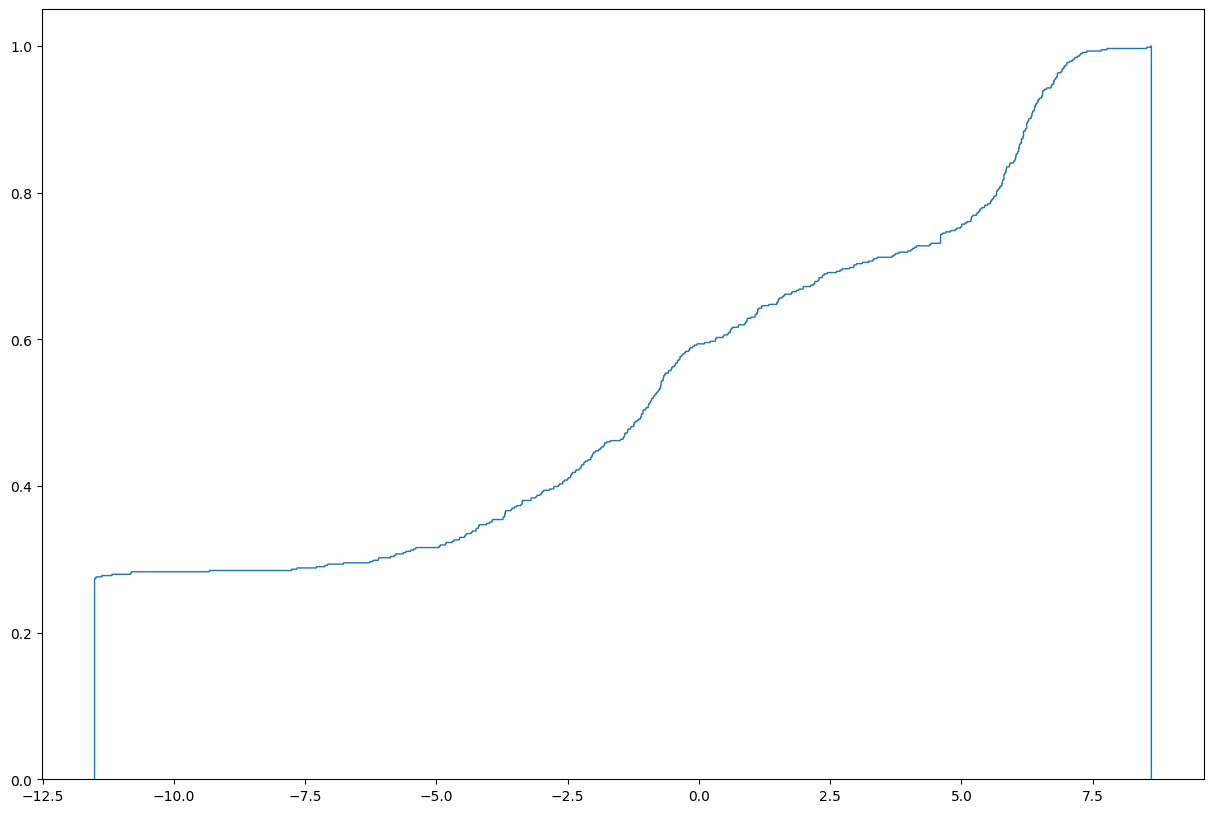

In [10]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=blockSize,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=8,
    n_head=8,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/diffusym8/2_var_set_transformer"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym8/ddim_step_1/2_var_set_transformer.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)